# Time Series Fit
In this example we shall demonstrate how to fit to a simple time series using 
``symfit``. We consider two seperate population which are interconverting: as 
one population decays exponentially, the other grows by the same amount.

Let us first create our model and some mock data, which will help illustrate
the situation.

In [40]:
from symfit import (
	BlockMatrix, MatrixSymbol, variables, parameters, CallableModel, Fit, 
	ODEModel, D
)
from symfit.distributions import Gaussian
from symfit.core.minimizers import *
import numpy as np
import matplotlib.pyplot as plt

In [13]:
N_t = 6
N_x = 201
mu1, sig1, mu2, sig2, A_param = parameters('mu1, sig1, mu2, sig2, A')
A_param.min = 0

Y = MatrixSymbol('Y', N_x, N_t)
x, y = variables('x, y')

B1 = MatrixSymbol('B1', N_x, 1)
B2 = MatrixSymbol('B2', N_x, 1)

b1 = Gaussian(x=x, mu=mu1, sig=sig1)
b2 = Gaussian(x=x, mu=mu2, sig=sig2)

A = MatrixSymbol(A_param, 2, N_t)
B = BlockMatrix([[B1, B2]])


In [14]:
model = CallableModel({
    Y: B * A,
    B1: b1,
    B2: b2
})
print(model)

[B1(x; mu1, sig1) = sqrt(2)*exp(-(-mu1 + x)**2/(2*sig1**2))/(2*sqrt(pi)*Abs(sig1)),
 B2(x; mu2, sig2) = sqrt(2)*exp(-(-mu2 + x)**2/(2*sig2**2))/(2*sqrt(pi)*Abs(sig2)),
 Y(A, B1, B2; ) = Matrix([[B1, B2]])*A]


Generate mock data

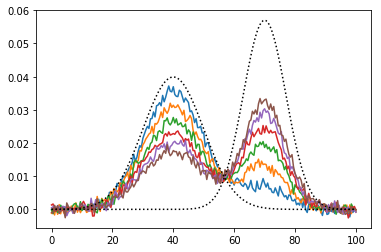

In [31]:
x_data = np.linspace(0, 100, N_x)[:, None]
t_data = np.linspace(10, 70, N_t)[None, :]

# The amplitudes of the populations
amp1 = np.exp(- 0.012 * t_data)
amp2 = np.atleast_2d(1 - amp1)
amp = np.block([[amp1], [amp2]])

ans = model(x=x_data, mu1=40, mu2=70, sig1=10, sig2=7, A=amp)
Y_data = ans.Y + np.random.normal(0, 0.001, ans.Y.shape)
for y_x in Y_data.T:
    plt.plot(x_data, y_x)
plt.plot(x_data[:, 0], ans.B1[:, 0], ls=':', color='black')
plt.plot(x_data[:, 0], ans.B2[:, 0], ls=':', color='black')
plt.show()


From how we build our model it is clear how we create matrix-valued parameters:
it is simply a matter of creating a `MatrixSymbol` from a `Parameter` like
``A = MatrixSymbol(Parameter('A'), 1, N_t)``. By addressing the parameter, 
bounds can also be set. Note that this has to be done to the `Parameter`, not 
the `MatrixSymbol`.

We are now ready to perform the fit.

In [32]:
mu1.value = 43
mu2.value = 73
sig1.value = 15
sig2.value = 15
fit = Fit(model, x=x_data, Y=Y_data, minimizer=LBFGSB)
fit_result = fit.execute()
print(fit_result)

Scalar Parameters:
Parameter | Value       | Standard Deviation
mu1         3.998166e+01  None
mu2         6.997511e+01  None
sig1        1.001504e+01  None
sig2        7.002317e+00  None

Tensor Parameters:
Parameter | Shape     | Flattened preview 
A           (2, 6)      [0.89 0.77 0.66 ... 0.43 0.51 0.57]

Status message         b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
Number of iterations   8
Objective              <symfit.core.objectives.LeastSquares object at 0x0000022957994EB8>
Minimizer              <symfit.core.minimizers.LBFGSB object at 0x0000022954967F98>
Linear Solver          <symfit.core.linear_solvers.LstSqBounds object at 0x0000022954967C88>

Goodness of fit qualifiers:
chi_squared            0.0011428119362241658
objective_value        0.0005714059681120829
r_squared              0.9896991522593261


Plotting the results demonstrates how well the fit has worked:

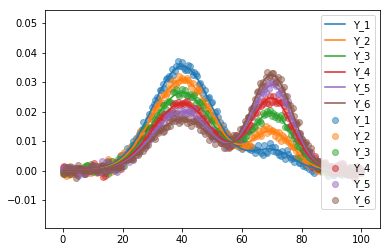

In [33]:
fit_ans = model(x=x_data, **fit_result.params)
for i, (y_x, y_fit) in enumerate(zip(Y_data.T, fit_ans.Y.T), start=1):
    plt.scatter(x_data[:, 0], y_x, label='Y_{}'.format(i), alpha=0.5)
    plt.plot(x_data[:, 0], y_fit, label='Y_{}'.format(i))
plt.legend()
plt.show()

Let us investigate the concentrations found by the fit:

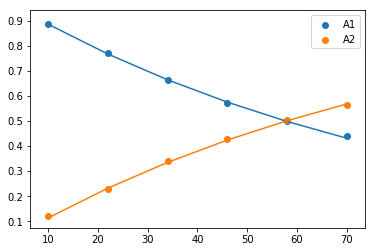

In [42]:
A1, A2 = fit_result.value(A)
plt.scatter(t_data[0], A1, label='A1')
plt.plot(t_data[0], amp1[0])
plt.scatter(t_data[0], A2, label='A2')
plt.plot(t_data[0], amp2[0])
plt.legend()
plt.show()

And now the pièce de résistance, can we obtain the rate constant of 0.012?

In [62]:
c1, c2, t = variables('c1, c2, t')
k, = parameters('k')
ode_model = ODEModel({D(c1, t): - k * c1, D(c2, t): k * c1}, 
					 initial={c1: A1[0], c2: A2[0], t: t_data[0, 0]})

ode_fit = Fit(ode_model, t=t_data[0], c1=A1, c2=A2, minimizer=NelderMead)
ode_result = ode_fit.execute()
print(ode_result)

Scalar Parameters:
Parameter | Value       | Standard Deviation
k           1.180039e-02  1.269400e-04
Status message         Optimization terminated successfully.
Number of iterations   35
Objective              <symfit.core.objectives.LeastSquares object at 0x0000022959D72DD8>
Minimizer              <symfit.core.minimizers.NelderMead object at 0x0000022959D72CF8>

Goodness of fit qualifiers:
chi_squared            0.00033197488970242156
objective_value        0.00016598744485121078
r_squared              0.9988390058247272


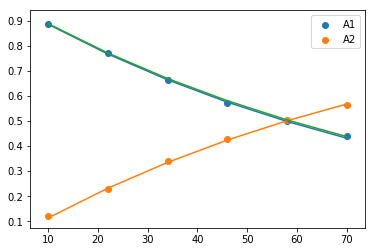

In [65]:
ans = ode_model(t=t_data[0], **ode_result.params)

plt.scatter(t_data[0], A1, label='A1')
plt.plot(t_data[0], amp1[0])
plt.scatter(t_data[0], A2, label='A2')
plt.plot(t_data[0], amp2[0])
plt.plot(t_data[0], ans[0])
plt.legend()
plt.show()

Yes, we can.

